# Predicting Wholesale Liquor Sales in Iowa

## Done By: Jilali Zhang, Josh Bumcroft, Mike Murley, Sam Carone and Wajdan Mahbub

## Sections:

**Section 1)** Project Information


**Section 2)** Data Source


**Section 3)** Data Cleaning


**Section 4)** Exploratory Data Analysis


**Section 5)** Modeling


**Section 6)** Analysis & Evaluation

**Section 7)** Conclusion & Recommendations

**Section 8)** Next Steps


## Section 1) Project Information

For this big data project, our team decided to examine whether it is possible to use machine learning models to predict wholesale liquor sales. This topic was intriguing because we wanted to see if predictive models could forecast sales with a high degree of accuracy. Additionally, we wanted to see if the onset of COVID-19 impacted sales, if specific liquor categories were more affected than others, and whether any correlation existed between liquor sales in specific categories and seasonality. The dataset we worked with was relatively easy to find as the state of Iowa maintains a comprehensive dataset on all wholesale liquor purchases by retailers within its borders. We used data from 2015 to 2019 to train our regression models from the state's database, and tested them against 2020 purchases. 

Our big data project aims to understand:
- Whether machine learning models can predict the number of bottles sold for any liquor category with a good level of accuracy.
- Whether machine learning models can predict the number of bottles sold in a city with a good level of accuracy. 
- Whether machine learning models can predict the number of bottles sold for a given bottle volume with a good level of accuracy. 
- Whether machine learning models get more accurate as they are retrained with new data. 

Making accurate predictions about future sales is an integral part of any business as it helps with workforce management, resource planning, and capital budgeting. For our case, making accurate predictions will help the wholesaler order the optimal number and mix of liquor from distilleries and importers. This will ensure that the wholesaler can use its warehouse space efficiently, minimize logistics and transportation costs, and appropriately respond to changes in the environment. Additionally, having a good prediction model will help the wholesaler optimize its operations by cutting down on unsold inventory and adjusting to changing demand. 

## Section 2) Data Source

**Liquor Sales Source:** Wholesale liquor sales were downloaded from: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/data

**Temperature Data Source:** Temperature data was downloaded from https://w2.weather.gov/climate/xmacis.php?wfo=dmx

This database on wholesale liquor sales is maintained by Iowa's Alcoholic Beverages Division, and updated at the end of each week. Unlike other states, Iowa maintains a monopoly on the wholesale distribution of liquor, making the state an alcoholic beverage control state. By maintaining a monopoly on the wholesale distribution of alcoholic beverages, the Alcoholic Beverages Division has managed to create a wholesale system that maximizes revenue for state and local governments and minimizes industry regulatory costs. In addition, the wholesale monopoly ensures that all retailers are treated equally regarding product pricing.

The dataset has over twenty million records, starting from January 2012 and ending in March 2021 (as of this project). For this project, we decided to look at wholesale liquor sales from January 2015 to December 2020. 

The temperature data was taken from the National Weather Service Forecast Office's website. We used this information to understand the impact of weather and temperature on liquor sales. The weather data itself comes with many variables such as minimum and maximum temperature, average temperature, precipitation, wind speeds, and even HDD (heating degree days) and CDD (cooling degree days). For our dataset, we only included the daily average temperature data.

## Section 3) Data Cleaning

Before we could train, validate and test our models, we had to clean the dataset. Given the size and granularity of the dataset, we had to simplify and consolidate some columns. The dataset from 2015 to 2020 consisted of 14.1 million rows and 24 columns. As several of the columns were not going to be used, we decided to remove them. Furthermore, some of the columns had too many unique values, which would be a problem when creating dummy variables to transform categorical values to numerical values; too many dummy variables could potentially crash our kernel. This is why we decided to consolidate some of the fields to just a handful of unique values. In total, we removed fourteen columns, consolidated the number of unique values in three columns, and added two new columns. 

Since the original dataset recorded transactions on a daily basis, we further consolidated our dataset to a weekly basis. All transactions were aggregated and grouped by year, week number, city, alcohol category, and bottle volume. As an added step, we removed any rows that had missing or duplicate values, which resulted in 9,288 rows being removed. All these steps reduced the number of rows from 14.1 million in the original dataset to 294,890 rows in the new dataset. The smaller dataset was a lot easier to analyze and use in Google Cloud.

### Sample Dataset from Alcoholic Beverages Division

In [85]:
# Sample Data path

origional_sample = "gs://is843_team_bucket/notebooks/jupyter/data/Iowa_Liquor_Sales/Iowa_Origional.csv"

# Loading Sample data

df_origional_sample = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load(origional_sample)

In [86]:
# Showing 5 rows of origional dataset

df_origional_sample.show(5)

+-------------------+--------+------------+--------------------+------------------+---------+--------+--------------+-------------+-------+--------+--------------------+-------------+-----------------+-----------+--------------------+----+------------------+-----------------+-------------------+------------+--------------+--------------------+---------------------+
|Invoice/Item Number|    Date|Store Number|          Store Name|           Address|     City|Zip Code|Store Location|County Number| County|Category|       Category Name|Vendor Number|      Vendor Name|Item Number|    Item Description|Pack|Bottle Volume (ml)|State Bottle Cost|State Bottle Retail|Bottles Sold|Sale (Dollars)|Volume Sold (Liters)|Volume Sold (Gallons)|
+-------------------+--------+------------+--------------------+------------------+---------+--------+--------------+-------------+-------+--------+--------------------+-------------+-----------------+-----------+--------------------+----+------------------+------

### 3.1) Changes to Dataset

**Columns Removed**

|Column Name|Description|Type|
|--|--|--|
|Store Number|Unique number of a retailer. |LongType|
|Store Name|Name of the retailer purchasing liquor. |StringType|
|Address|Local street address of the retailer. |StringType|
|Zip Code|Local zip code of the retailer. |LongType|
|Store Location|Longitude and latitude of a retailer. |StringType|
|County Number|Unique number given to a county in Iowa. |LongType|
|County|Name of the country in Iowa where the retailer is located. |StringType|
|Vendor Number|Unique number of distributors that the Alcoholic Beverages Division purchased the liquor from. |LongType|
|Vendor Name|Name of the distributor that the Alcoholic Beverages Division purchased the liquor from. |StringType|
|Item Number|Unqiue number for the specific liquor purchased by the Alcoholic Beverages Division. |LongType|
|Item Description|Name of the specific liquor purchased by the Alcoholic Beverages Division. |StringType|
|Pack|Identifies how many bottles are inside the box. |LongType|
|Volume Sold (Liters)|Volume of liquor in liters that was purchased by the retailer. |DoubleType|
|Volume Sold (Gallons)|Volume of liquor in gallons that was purchased by the retailer. |DoubleType|

Description:

We decided to remove these 14 columns because they will not be used in our machine learning models. Removing these columns will also reduce the size of the csv file in our team's storage bucket, and reduce the processing power taken to read it. 

**Columns Consolidated**

|Column Name|Description|Type|Unique Values Before|New Name|Unqiue Values After|
|--|--|--|--|--|--|
|City|Identifies which city the retailer is located in. |StringType|447 |City_Consolidated| 21|
|Category|Identifies what type of liquor was purchased by the retailer. |StringType|131| Category_Consolidated|10|
|Bottle Volume (ml)|Identifies the bottle volume of of the type of liquor purchased |StringType| 17 | Bottle_Volume_ml_Consolidated|6|


Description:

We decided to consolidate the number of unique values in 'City', 'Category' and 'Bottle Volume (ml)' because not doing so would result in us having to create 446 dummy variables for 'City', 130 dummy variables for 'Category' and 16 dummy variables for 'Bottle Volume (ml)'. By consolidating each column's unique values, we only had to create twenty dummy variables for 'City', nine dummy variables for 'Category' and five dummy variables for 'Bottle Volume (ml)'. The cities we selected were the top twenty cities in Iowa in terms of liquor purchases. The nine categories for liquor are the main liquor categories that most alcoholic beverages fall into. Finally, the five bottle volumes are the ones that are the most popular in Iowa. 

**Columns Added**

|Column Name|Type|
|--|--|
|Year|LongType|
|Week_Number|LongType|
|Sequential_Week_Number|LongType|
|Gross_Profit_Total|DoubleType|
|Mean_Temp_F_Avg|DoubleType|

Description:

By aggregating the data by week number, we could significantly decrease the number of rows in our data set. This reduced the computational resources needed to analyze the data, and train and test our models. The mean daily temperature was added to the dataset to see how changes in temperature impact liquor sales. 

### 3.2) New Dataset ###

**Data Dictionary**

|Column Name|Description|Type|
|--|--|--|
|Year|The year of the liquor purchase made by a retailer.|LongType|
|Week_Number|The week number of the liquor purchase made by a retailer.|LongType|
|Sequential_Week_Number|The week number after the first week of 2015.|LongType|
|City_Consolidated|The field identifies which city the retailer is located in.|StringType|
|Category_Consolidated|The field provides the description of the alcohol type purchased by a retailer.|StringType|
|Bottle_Volume_ml_Consolidated|The field indicates the quantity of alcohol in milliliters per bottle. |StringType|
|Bottle_Price_Avg|The price the wholesaler charges to retailers for a bottle.|DoubleType|
|Bottles_Sold_Total|The number of bottles sold to a retailer.|LongType|
|Sales_Revenue_Total|The revenue generated from selling to retailers, calculated as Bottle_Price * Bottles_Sold.|DoubleType|
|Gross_Profit_Total|The wholesaler's gross profit, calculated as (Bottle_Price - Bottle_Cost) * Bottles_Sold.|DoubleType|
|Mean_Temp_F_Avg|The field indicates the average daily temperature in the state. The unite of measure is Fahrenheit (F). |DoubleType|

**Description:** 

The final dataset we will be working with contains 11 columns and 294K rows. This dataset is much easier to work with because we have eliminated redundant columns, consolidated unique values in two columns, and added a few new columns to analyze the data on a higher level. 


**Questions for EDA:** 

Looking at this dataset, we would like to know:

1) What are the top three liquor categories in terms of bottles sold? How much did they generate in terms of gross profit?

2) What is the gross margin on an annual basis? 

3) What year witnessed the most bottles sold and highest gross profit?

3) When do retailers purchase the most and least?

4) What are the top three cities for in terms of bottles sold and gross profit?

6) Does gross margin differ on a city-by-city basis?

7) What is the distribution of liquor prices?

8) Are there any variables that show multicollinearity?

In [87]:
# Libraries

from pyspark.sql.types import (StructType, StructField, DateType, BooleanType, DoubleType, IntegerType,StringType, LongType) 

# Sample Data Path

data = "gs://is843_team_bucket/notebooks/jupyter/data/Iowa_Liquor_Sales/Iowa_Liquor_Sales_Weekly.csv"

# Custom Schema for New Dataset

custom_schema = StructType([
    StructField('Year', LongType(), True),
    StructField('Week_Number', LongType(), True),
    StructField('Sequential_Week_Number', LongType(), True),
    StructField('City_Consolidated', StringType(), True),
    StructField('Category_Consolidated', StringType(), True),
    StructField('Bottle_Volume_ml_Consolidated', StringType(), True),
    StructField('Mean_Temp_F_Avg', DoubleType(), True),
    StructField('Bottle_Price_Avg', DoubleType(), True),
    StructField('Bottles_Sold_Total', LongType(), True),
    StructField('Sales_Revenue_Total', DoubleType(), True),
    StructField('Gross_Profit_Total', DoubleType(), True)
])

# Loading Sample Data

df = spark.read.format("csv")\
    .option("header", "True")\
    .schema(custom_schema) \
    .load(data)


In [89]:
df.printSchema()

root
 |-- Year: long (nullable = true)
 |-- Week_Number: long (nullable = true)
 |-- Sequential_Week_Number: long (nullable = true)
 |-- City_Consolidated: string (nullable = true)
 |-- Category_Consolidated: string (nullable = true)
 |-- Bottle_Volume_ml_Consolidated: string (nullable = true)
 |-- Mean_Temp_F_Avg: double (nullable = true)
 |-- Bottle_Price_Avg: double (nullable = true)
 |-- Bottles_Sold_Total: long (nullable = true)
 |-- Sales_Revenue_Total: double (nullable = true)
 |-- Gross_Profit_Total: double (nullable = true)



In [90]:
df.show(5)

+----+-----------+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+------------------+
|Year|Week_Number|Sequential_Week_Number|City_Consolidated|Category_Consolidated|Bottle_Volume_ml_Consolidated|Mean_Temp_F_Avg|Bottle_Price_Avg|Bottles_Sold_Total|Sales_Revenue_Total|Gross_Profit_Total|
+----+-----------+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+------------------+
|2015|          2|                     2|           Ankeny|               Brandy|                        Other|            0.0|            8.88|                 1|               8.88|              2.96|
|2015|          2|                     2|           Ankeny|             Schnapps|                          375|            6.5|            4.61|                 1|               4.61|     

In [ ]:
# Code to generate tables on a weekly basis

spark.sql(
"""
    
INSERT INTO [Iowa_Liquor_Sales_Weekly]

SELECT *

FROM (

(SELECT   
[Year]
,DATEPART(WW, [Date]) AS [Week_Number]
,[City_Consolidated]
,[Category_Consolidated]
,MAX(CASE 
WHEN [Bottle_Volume_ml] = 100 THEN 100
WHEN [Bottle_Volume_ml] = 200 THEN 200
WHEN [Bottle_Volume_ml] = 375 THEN 375
WHEN [Bottle_Volume_ml] = 750 THEN 750
WHEN [Bottle_Volume_ml] = 1000 THEN 1000
ELSE 'Other'
END) AS [Bottle_Volume_ml_Consolidated]
,ROUND(AVG([Mean_Temp_F]),2) AS [Mean_Temp_F_Avg]
,ROUND(SUM([Sales_Revenue]) / SUM([Bottles_Sold]),2) AS [Bottle_Price_Avg]
,SUM([Bottles_Sold]) AS [Bottles_Sold_Total]
,ROUND(SUM([Sales_Revenue]),2) AS [Sales_Revenue_Total]
,ROUND(SUM([Gross_Profit]),2) AS [Gross_Profit_Total]
 
FROM [Big_Data_Projects].[dbo].[Iowa]
WHERE [Bottle_Volume_ml] NOT IN (100,200,375,750,1000)

GROUP BY [Year],  DATEPART(WW, [Date]), [City_Consolidated], [Category_Consolidated] )

UNION

(SELECT   
[Year]
,DATEPART(WW, [Date]) AS [Week_Number]
,[City_Consolidated]
,[Category_Consolidated]
,(CASE 
WHEN [Bottle_Volume_ml] = 100 THEN 100
WHEN [Bottle_Volume_ml] = 200 THEN 200
WHEN [Bottle_Volume_ml] = 375 THEN 375
WHEN [Bottle_Volume_ml] = 750 THEN 750
WHEN [Bottle_Volume_ml] = 1000 THEN 1000
ELSE 'Other'
END) AS [Bottle_Volume_ml_Consolidated]
,ROUND(AVG([Mean_Temp_F]),2) AS [Mean_Temp_F_Avg]
,ROUND(SUM([Sales_Revenue]) / SUM([Bottles_Sold]),2) AS [Bottle_Price_Avg]
,SUM([Bottles_Sold]) AS [Bottles_Sold_Total]
,ROUND(SUM([Sales_Revenue]),2) AS [Sales_Revenue_Total]
,ROUND(SUM([Gross_Profit]),2) AS [Gross_Profit_Total]
 
FROM [Big_Data_Projects].[dbo].[Iowa]
WHERE [Bottle_Volume_ml] IN (100,200,375,750,1000)

GROUP BY [Year],  DATEPART(WW, [Date]), [City_Consolidated], [Category_Consolidated], [Bottle_Volume_ml])

) AS [Weekly_Consolidated] ) """) 


**Caching Spark Dataframe**

In [91]:
# Importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql import functions as F

In [92]:
# Repartition master dataset 

df = df.repartition(10)

print("Data was re-partitioned to {} partitions.".format(df.rdd.getNumPartitions()))

# Number of shuffle partitions

spark.conf.set("spark.sql.shuffle.partitions", "10")

# Caching the DataFrame

df.cache()

Data was re-partitioned to 10 partitions.


DataFrame[Year: bigint, Week_Number: bigint, Sequential_Week_Number: bigint, City_Consolidated: string, Category_Consolidated: string, Bottle_Volume_ml_Consolidated: string, Mean_Temp_F_Avg: double, Bottle_Price_Avg: double, Bottles_Sold_Total: bigint, Sales_Revenue_Total: double, Gross_Profit_Total: double]

In [93]:
orig_rows = df.count()
orig_columns = columns= len(df.columns)

print("The weekly liquor sales Spark dataframe has {:,} rows and {} columns.".format(orig_rows, orig_columns))

The weekly liquor sales Spark dataframe has 304,178 rows and 11 columns.


### 3.3) Dropping Rows with Null Values

In [94]:
# Check null values for each column

null_value_cols = [( df.where(col(c).isNull()).count(), format(df.where(col(c).isNull()).count()/orig_rows, ".2%") , c) for c in df.columns]
null_value_cols.sort(reverse = True)
null_value_cols

[(4908, '1.61%', 'City_Consolidated'),
 (4457, '1.47%', 'Category_Consolidated'),
 (0, '0.00%', 'Year'),
 (0, '0.00%', 'Week_Number'),
 (0, '0.00%', 'Sequential_Week_Number'),
 (0, '0.00%', 'Sales_Revenue_Total'),
 (0, '0.00%', 'Mean_Temp_F_Avg'),
 (0, '0.00%', 'Gross_Profit_Total'),
 (0, '0.00%', 'Bottles_Sold_Total'),
 (0, '0.00%', 'Bottle_Volume_ml_Consolidated'),
 (0, '0.00%', 'Bottle_Price_Avg')]

In [95]:
column_name1 = null_value_cols[0][2]
column_name2 = null_value_cols[1][2]
column_null_count1 = null_value_cols[0][0]
column_null_count2 = null_value_cols[1][0]
column_null_p1 = null_value_cols[0][1]
column_null_p2 = null_value_cols[1][1]

print(f'{column_name1} has {column_null_count1:,} null values, which affects only {column_null_p1} of the rows in the dataset.')
print(f'{column_name2} has {column_null_count2:,} null values, which affects only {column_null_p2} of the rows in the dataset.')

City_Consolidated has 4,908 null values, which affects only 1.61% of the rows in the dataset.
Category_Consolidated has 4,457 null values, which affects only 1.47% of the rows in the dataset.


In [96]:
df = df.dropna()

null_value_cols = [(df.where(col(c).isNull()).count() , c) for c in df.columns]
null_value_cols.sort(reverse = True)
null_value_cols

[(0, 'Year'),
 (0, 'Week_Number'),
 (0, 'Sequential_Week_Number'),
 (0, 'Sales_Revenue_Total'),
 (0, 'Mean_Temp_F_Avg'),
 (0, 'Gross_Profit_Total'),
 (0, 'City_Consolidated'),
 (0, 'Category_Consolidated'),
 (0, 'Bottles_Sold_Total'),
 (0, 'Bottle_Volume_ml_Consolidated'),
 (0, 'Bottle_Price_Avg')]

### 3.4) Dropping Duplicate Values

In [97]:
before_dup = df.count()

df_total = df.drop_duplicates()

after_dup = df.count()

print(f'The weekly liquor sales Spark dataframe has {before_dup - after_dup:,} duplicate rows, whice have been removed.')

The weekly liquor sales Spark dataframe has 0 duplicate rows, whice have been removed.


In [98]:
new_rows = df.count()
new_columns = len(df.columns)

print("The weekly liquor sales Spark dataframe has {:,} rows and {} columns after dropping 9,288 rows that had null values or duplicate values.".format(new_rows, new_columns ))

The weekly liquor sales Spark dataframe has 294,890 rows and 11 columns after dropping 9,288 rows that had null values or duplicate values.


## Section 4) Exploratory Data Analysis

### 4.1) Basic Statistics

In [99]:
# Seperating 2015-2019 data from 2020 data

df_2020 = df.filter(df['Year'] == 2020)
df_2015_2019 = df.filter(df['Year'] < 2020)

In [100]:
df_2015_2019.describe(['Bottle_Price_Avg','Bottles_Sold_Total', 'Sales_Revenue_Total', 'Gross_Profit_Total', 'Mean_Temp_F_Avg' ]).show()

+-------+-----------------+------------------+-------------------+------------------+------------------+
|summary| Bottle_Price_Avg|Bottles_Sold_Total|Sales_Revenue_Total|Gross_Profit_Total|   Mean_Temp_F_Avg|
+-------+-----------------+------------------+-------------------+------------------+------------------+
|  count|           242695|            242695|             242695|            242695|            242695|
|   mean|12.21995343950221| 492.3908156327901|  6461.879121119048| 2156.206374832617|52.622755969426144|
| stddev|7.090384559083239|1519.8746558986238|  23208.58378997177|  7749.71277707529| 20.87734329579128|
|    min|             1.34|                 1|               1.34|              0.45|               0.0|
|    max|           185.47|             44555|          854284.32|         284854.83|              88.0|
+-------+-----------------+------------------+-------------------+------------------+------------------+



### 4.2) Exploratory Questions

**Analysis of Liquor Categories**

In [101]:
# Rank the liquor types based on bottles sold from 2015-2019

liquor_types = df_2015_2019.groupBy("Category_Consolidated")\
.agg({'Bottles_Sold_Total':'sum', 'Sales_Revenue_Total':'sum', 'Gross_Profit_Total': 'sum', 'Bottle_Price_Avg':'avg'})\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.withColumnRenamed("SUM(Sales_Revenue_Total)", "Sales_Revenue")\
.withColumnRenamed("SUM(Gross_Profit_Total)", "Gross_Profit")\
.withColumnRenamed("AVG(Bottle_Price_Avg)", "Bottle_Price_Avg")\
.orderBy(F.desc("Bottles_Sold"))

# Convert the aggregation to a Pandas Dataframe

liquor_types_pd = liquor_types.toPandas()

# Convert all values to millions

liquor_types_pd['Bottles_Sold'] = liquor_types_pd['Bottles_Sold'] / 1000000
liquor_types_pd['Gross_Profit'] = liquor_types_pd['Gross_Profit'] / 1000000
liquor_types_pd['Sales_Revenue'] = liquor_types_pd['Sales_Revenue'] / 1000000
liquor_types_pd['Gross_Margin_%'] = liquor_types_pd['Gross_Profit'] / liquor_types_pd['Sales_Revenue'] * 100

liquor_types_pd = liquor_types_pd.round({'Bottles_Sold':2,'Gross_Profit':2, 'Sales_Revenue':2,'Gross_Margin_%':2, 'Bottle_Price_Avg':2  })

liquor_types_pd[[ 'Category_Consolidated', 'Bottles_Sold', 'Bottle_Price_Avg', 'Sales_Revenue', 'Gross_Profit', 'Gross_Margin_%' ] ]


,Category_Consolidated,Bottles_Sold,Bottle_Price_Avg,Sales_Revenue,Gross_Profit,Gross_Margin_%
0,Whisky,37.53,12.47,578.74,193.21,33.38
1,Vodka,35.94,9.13,382.43,127.60,33.37
2,Rum,13.26,11.16,184.46,61.52,33.35
3,Liqueur,8.18,13.71,100.23,33.43,33.35
4,Brandy,6.65,12.51,73.17,24.40,33.35
5,Tequilla,5.14,17.01,92.58,30.87,33.35
6,Schnapps,4.59,10.47,52.75,17.59,33.34
7,Other,3.75,12.95,53.55,17.88,33.40
8,Gin,3.33,10.41,39.37,13.13,33.36
9,Spirit,1.12,13.01,11.00,3.67,33.38


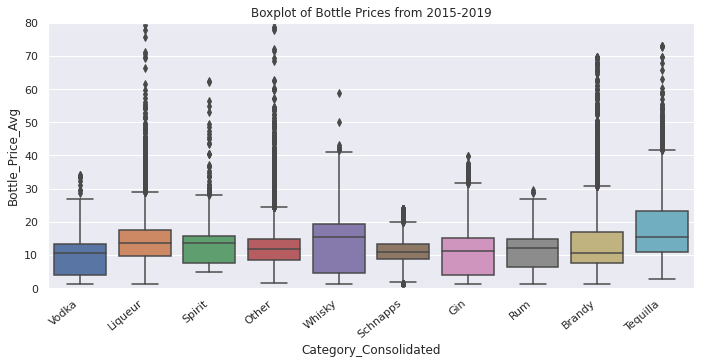

In [132]:
# Boxplot of liquor prices

df_2015_2019_pd = df_2015_2019.toPandas()
plt.figure(figsize=(10,5))
ax1 = sns.boxplot(x="Category_Consolidated", y="Bottle_Price_Avg", data=df_2015_2019_pd)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Boxplot of Bottle Prices from 2015-2019')
plt.ylim([0,80])
plt.show()


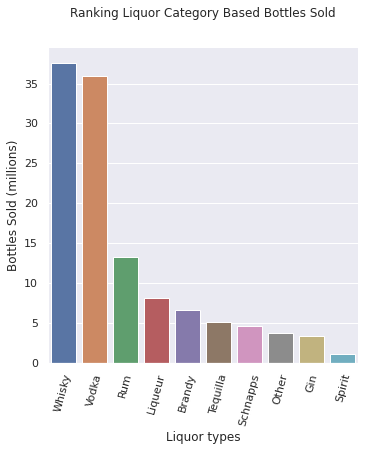

In [102]:
# Bar graph of bottles sold for liquor categories

sns.catplot(data=liquor_types_pd, x="Category_Consolidated", y="Bottles_Sold",kind="bar")
plt.title("Ranking Liquor Category Based Bottles Sold", y=1.08)
plt.xlabel("Liquor types")
plt.ylabel("Bottles Sold (millions)")
plt.xticks(rotation=75)
plt.show()

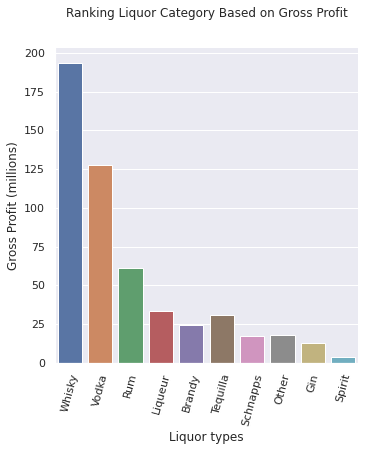

In [103]:
# Bar graph of gross profit for liquor categories

sns.catplot(data=liquor_types_pd, x="Category_Consolidated", y="Gross_Profit",kind="bar")
plt.title("Ranking Liquor Category Based on Gross Profit", y=1.08)
plt.xlabel("Liquor types")
plt.ylabel("Gross Profit (millions)")
plt.xticks(rotation=75)
plt.show()

**Analysis of Years**

In [104]:
# Rank the total liquor revenue of different years from 2015-2019

years = df_2015_2019.groupBy("Year")\
.agg({'Bottles_Sold_Total':'sum', 'Sales_Revenue_Total':'sum', 'Gross_Profit_Total': 'sum', 'Bottle_Price_Avg': 'avg'})\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.withColumnRenamed("SUM(Sales_Revenue_Total)", "Sales_Revenue")\
.withColumnRenamed("SUM(Gross_Profit_Total)", "Gross_Profit")\
.withColumnRenamed("AVG(Bottle_Price_Avg)", "Bottle_Price_Avg")\
.orderBy(F.desc("Sales_Revenue"))

# Convert the aggregation to a Pandas Dataframe

years_pd = years.toPandas()

# Convert all values to millions

years_pd['Bottles_Sold'] = years_pd['Bottles_Sold'] / 1000000
years_pd['Gross_Profit'] = years_pd['Gross_Profit'] / 1000000
years_pd['Sales_Revenue'] = years_pd['Sales_Revenue'] / 1000000
years_pd['Gross_Margin_%'] = years_pd['Gross_Profit'] / years_pd['Sales_Revenue'] * 100

years_pd = years_pd.round({'Bottles_Sold':2,'Gross_Profit':2, 'Sales_Revenue':2,'Gross_Margin_%':2, 'Bottle_Price_Avg':2 })
years_pd[[ 'Year', 'Bottles_Sold', 'Bottle_Price_Avg', 'Sales_Revenue', 'Gross_Profit', 'Gross_Margin_%' ] ]

years_pd = years_pd.sort_values(by=['Sales_Revenue'], ascending= False).reset_index(drop= True)
years_pd

,Year,Gross_Profit,Bottles_Sold,Sales_Revenue,Bottle_Price_Avg,Gross_Margin_%
0,2019,116.14,26.78,348.30,12.44,33.35
1,2018,111.25,25.38,333.64,12.24,33.34
2,2017,102.88,23.49,308.52,12.21,33.35
3,2016,98.09,22.30,293.86,12.18,33.38
4,2015,94.94,21.55,283.94,12.02,33.44


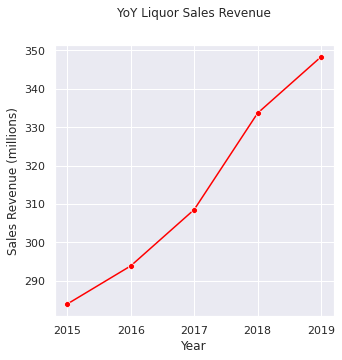

In [108]:
# Line graph of sales revenue by year

plt.figure(figsize=(5,5))
sns.lineplot(data= years_pd, x="Year", y="Sales_Revenue",color='red', marker='o')
plt.title("YoY Liquor Sales Revenue", y=1.08)
plt.ylabel("Sales Revenue (millions)")
plt.grid(True)
plt.show();

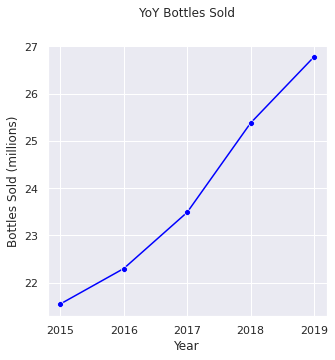

In [109]:
# Line graph of bottles sold by year

plt.figure(figsize=(5,5))
sns.lineplot(data= years_pd, x="Year", y="Bottles_Sold",color='blue', marker='o')
plt.title("YoY Bottles Sold", y=1.08)
plt.ylabel("Bottles Sold (millions)")
plt.grid(True)
plt.show()

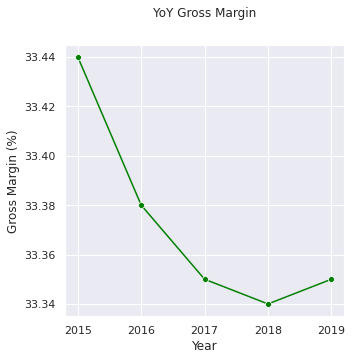

In [110]:
# Line graph of gross margin by year

plt.figure(figsize=(5,5))
sns.lineplot(data= years_pd, x="Year", y="Gross_Margin_%",color='green', marker='o')
plt.title("YoY Gross Margin", y=1.08)
plt.ylabel("Gross Margin (%)")
plt.grid(True)
plt.show()

**Analysis of Weeks**

In [112]:
# Stats by week number from 2015-2019

weeks = df_2015_2019.groupBy('Week_Number')\
.agg({'Bottles_Sold_Total':'avg', 'Sales_Revenue_Total':'avg', 'Gross_Profit_Total': 'avg', 'Bottle_Price_Avg': 'avg'})\
.withColumnRenamed("AVG(Bottles_Sold_Total)", "Bottles_Sold_Avg")\
.withColumnRenamed("AVG(Sales_Revenue_Total)", "Sales_Revenue_Avg")\
.withColumnRenamed("AVG(Gross_Profit_Total)", "Gross_Profit_Avg")\
.withColumnRenamed("AVG(Bottle_Price_Avg)", "Bottle_Price_Avg")\
.orderBy(F.desc("Week_Number"))

# Convert the aggregation to a Pandas Dataframe

weeks_pd = weeks.toPandas()

weeks_pd['Gross_Margin_%_Avg'] = weeks_pd['Gross_Profit_Avg'] / weeks_pd['Sales_Revenue_Avg'] * 100

weeks_pd = weeks_pd.round({'Bottles_Sold_Avg':2,'Gross_Profit_Avg':2, 'Sales_Revenue_Avg':2,'Gross_Margin_%_Avg':2, 'Bottle_Price_Avg': 2 })
weeks_pd  = weeks_pd[[ 'Week_Number', 'Bottles_Sold_Avg', 'Bottle_Price_Avg','Sales_Revenue_Avg', 'Gross_Profit_Avg', 'Gross_Margin_%_Avg' ] ]

weeks_pd = weeks_pd.sort_values(by=['Week_Number']).reset_index(drop= True)
weeks_pd


,Week_Number,Bottles_Sold_Avg,Bottle_Price_Avg,Sales_Revenue_Avg,Gross_Profit_Avg,Gross_Margin_%_Avg
0,1,333.31,12.41,4306.91,1436.13,33.34
1,2,438.89,12.05,5534.26,1846.46,33.36
2,3,423.39,11.97,5331.19,1778.75,33.36
3,4,385.63,12.01,4777.80,1594.03,33.36
4,5,440.35,11.89,5573.02,1859.42,33.36
5,6,495.61,12.24,6627.48,2214.50,33.41
6,7,463.39,12.17,6129.29,2047.53,33.41
7,8,444.21,12.09,5743.76,1917.89,33.39
8,9,455.10,12.04,5810.10,1940.80,33.40
9,10,477.07,12.31,6296.64,2100.44,33.36


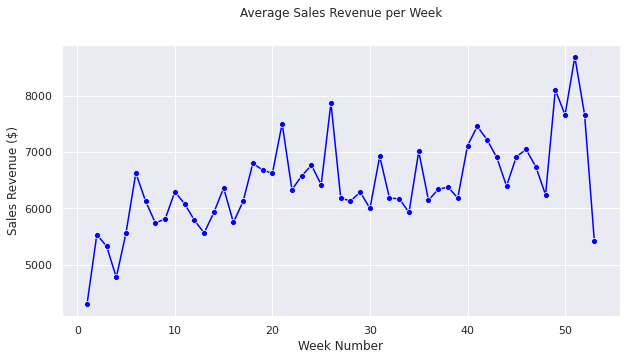

In [114]:
# Line graph of average sales revenue by month

plt.figure(figsize=(10,5))
sns.lineplot(data = weeks_pd, x="Week_Number", y="Sales_Revenue_Avg", color='blue', marker='o')
plt.title("Average Sales Revenue per Week", y=1.08)
plt.ylabel("Sales Revenue ($)")
plt.xlabel("Week Number")
plt.grid(True)
plt.show()

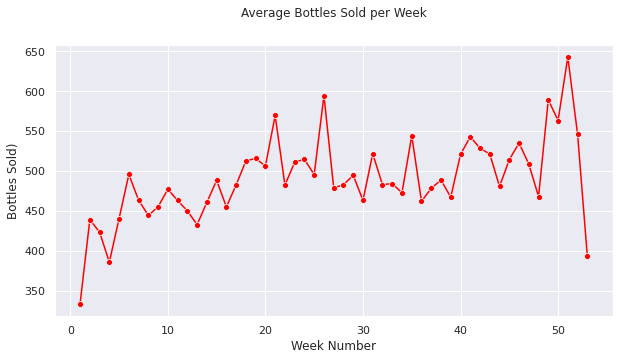

In [115]:
# Line graph of average bottles sold by month

plt.figure(figsize=(10,5))
sns.lineplot(data = weeks_pd, x="Week_Number", y="Bottles_Sold_Avg", color='red', marker='o')
plt.title("Average Bottles Sold per Week", y=1.08)
plt.ylabel("Bottles Sold)")
plt.xlabel("Week Number")
plt.grid(True)
plt.show()

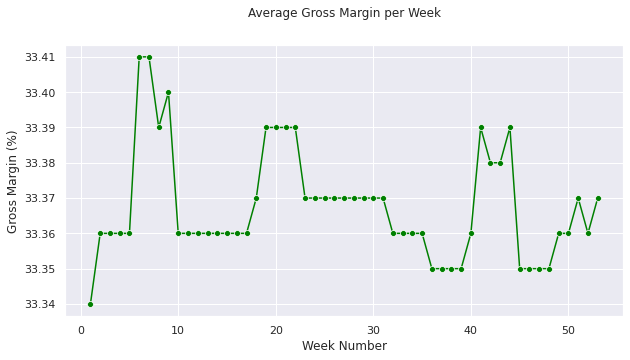

In [116]:
# Line graph of average gross margin by month

plt.figure(figsize=(10,5))
sns.lineplot(data= weeks_pd, x="Week_Number", y="Gross_Margin_%_Avg",color='green', marker='o')
plt.title("Average Gross Margin per Week", y=1.08)
plt.ylabel("Gross Margin (%)")
plt.xlabel("Week Number")
plt.grid(True)
plt.show()

**Analysis of Cities**

In [117]:
#Rank total liquor revenue by city from 2015-2019

cities = df_2015_2019.groupBy("City_Consolidated")\
.agg({'Bottles_Sold_Total':'sum', 'Sales_Revenue_Total':'sum', 'Gross_Profit_Total': 'sum', 'Bottle_Price_Avg': 'avg'})\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.withColumnRenamed("SUM(Sales_Revenue_Total)", "Sales_Revenue")\
.withColumnRenamed("SUM(Gross_Profit_Total)", "Gross_Profit")\
.withColumnRenamed("AVG(Bottle_Price_Avg)", "Bottle_Price_Avg")\
.orderBy(F.desc("Sales_Revenue"))

# Convert the aggregation to a Pandas Dataframe

cities_pd = cities.toPandas()

# Convert all values to millions

cities_pd['Bottles_Sold'] = cities_pd['Bottles_Sold'] / 1000000
cities_pd['Gross_Profit'] = cities_pd['Gross_Profit'] / 1000000
cities_pd['Sales_Revenue'] = cities_pd['Sales_Revenue'] / 1000000
cities_pd['Gross_Margin_%'] = cities_pd['Gross_Profit'] / cities_pd['Sales_Revenue'] * 100

cities_pd = cities_pd.round({'Bottles_Sold':2,'Gross_Profit':2, 'Sales_Revenue':2,'Gross_Margin_%':2, 'Bottle_Price_Avg': 2 })

cities_pd = cities_pd[cities_pd['City_Consolidated'] != 'Other'  ]
cities_pd = cities_pd[[ 'City_Consolidated', 'Bottles_Sold', 'Bottle_Price_Avg','Sales_Revenue', 'Gross_Profit', 'Gross_Margin_%']]
cities_pd

,City_Consolidated,Bottles_Sold,Bottle_Price_Avg,Sales_Revenue,Gross_Profit,Gross_Margin_%
1,Des Moines,15.72,11.93,200.77,66.97,33.35
2,Cedar Rapids,8.35,11.66,104.57,34.89,33.37
3,Davenport,6.96,11.56,79.90,26.65,33.36
4,West Des Moines,3.70,13.41,58.65,19.56,33.36
5,Waterloo,5.07,11.65,55.13,18.39,33.37
6,Sioux City,4.08,11.85,53.44,17.83,33.36
7,Iowa City,3.93,12.05,53.19,17.75,33.36
8,Council Bluffs,4.08,11.71,52.54,17.52,33.36
9,Dubuque,3.20,12.28,43.51,14.52,33.37
10,Ames,2.92,12.31,41.97,14.00,33.37


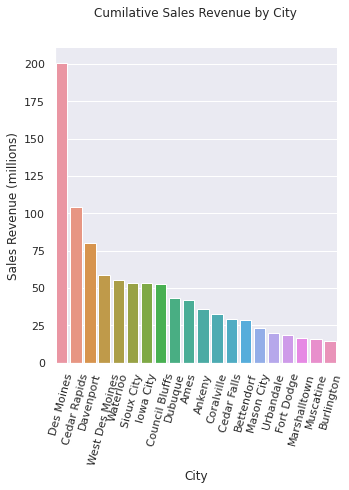

In [119]:
# Bar graph of sales revenue by city

#plt.figure(figsize=(5,5))
sns.catplot(data=cities_pd, x="City_Consolidated", y="Sales_Revenue", kind="bar")
plt.title("Cumilative Sales Revenue by City", y=1.08)
plt.xlabel("City")
plt.ylabel("Sales Revenue (millions)")
plt.xticks(rotation=75)
plt.show();

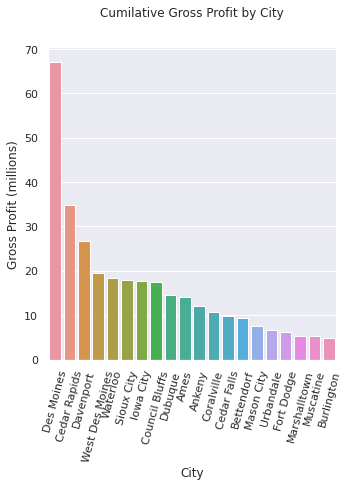

In [120]:
# Bar graph of gross profit by city

#plt.figure(figsize=(5,5))
sns.catplot(data=cities_pd, x="City_Consolidated", y="Gross_Profit", kind="bar")
plt.title("Cumilative Gross Profit by City", y=1.08)
plt.xlabel("City")
plt.ylabel("Gross Profit (millions)")
plt.xticks(rotation=75)
plt.show()

#### 4.5.5) In-depth Look into 2020

**Analysis of Liquor Categories in 2020**

In [121]:
liquor_types = df_2020.groupBy("Category_Consolidated")\
.agg({'Bottles_Sold_Total':'sum', 'Sales_Revenue_Total':'sum', 'Gross_Profit_Total': 'sum', 'Bottle_Price_Avg': 'avg'})\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.withColumnRenamed("SUM(Sales_Revenue_Total)", "Sales_Revenue")\
.withColumnRenamed("SUM(Gross_Profit_Total)", "Gross_Profit")\
.withColumnRenamed("AVG(Bottle_Price_Avg)", "Bottle_Price_Avg")\
.orderBy(F.desc("Bottles_Sold"))

# Convert the aggregation to a Pandas Dataframe

liquor_types_pd = liquor_types.toPandas()

# Convert all values to millions

liquor_types_pd['Bottles_Sold'] = liquor_types_pd['Bottles_Sold'] / 1000000
liquor_types_pd['Gross_Profit'] = liquor_types_pd['Gross_Profit'] / 1000000
liquor_types_pd['Sales_Revenue'] = liquor_types_pd['Sales_Revenue'] / 1000000
liquor_types_pd['Gross_Margin_%'] = liquor_types_pd['Gross_Profit'] / liquor_types_pd['Sales_Revenue'] * 100

liquor_types_pd = liquor_types_pd.round({'Bottles_Sold':2,'Gross_Profit':2, 'Sales_Revenue':2,'Gross_Margin_%':2, 'Bottle_Price_Avg':2 })

liquor_types_pd[[ 'Category_Consolidated', 'Bottles_Sold', "Bottle_Price_Avg", 'Sales_Revenue', 'Gross_Profit', 'Gross_Margin_%' ] ]

,Category_Consolidated,Bottles_Sold,Bottle_Price_Avg,Sales_Revenue,Gross_Profit,Gross_Margin_%
0,Whisky,10.85,12.48,150.99,50.34,33.34
1,Vodka,8.12,9.00,89.04,29.69,33.35
2,Rum,2.76,11.45,39.36,13.12,33.34
3,Brandy,1.65,15.80,22.18,7.40,33.37
4,Liqueur,1.57,14.61,23.56,7.86,33.34
5,Tequilla,1.40,17.39,26.75,8.92,33.34
6,Other,1.39,13.28,20.31,6.77,33.34
7,Schnapps,1.02,9.74,11.22,3.74,33.34
8,Gin,0.68,11.23,8.85,2.95,33.35
9,Spirit,0.39,13.83,4.50,1.50,33.37


**Analysis of Weeks in 2020**

In [123]:
weeks = df_2020.groupBy('Week_Number')\
.agg({'Bottles_Sold_Total':'avg', 'Sales_Revenue_Total':'avg', 'Gross_Profit_Total': 'avg'})\
.withColumnRenamed("AVG(Bottles_Sold_Total)", "Bottles_Sold_Avg")\
.withColumnRenamed("AVG(Sales_Revenue_Total)", "Sales_Revenue_Avg")\
.withColumnRenamed("AVG(Gross_Profit_Total)", "Gross_Profit_Avg")\
.orderBy(F.desc("Week_Number"))

# Convert the aggregation to a Pandas Dataframe

weeks_pd = weeks.toPandas()

weeks_pd['Gross_Margin_%_Avg'] = weeks_pd['Gross_Profit_Avg'] / weeks_pd['Sales_Revenue_Avg'] * 100

weeks_pd = weeks_pd.round({'Bottles_Sold_Avg':2,'Gross_Profit_Avg':2, 'Sales_Revenue_Avg':2,'Gross_Margin_%_Avg':2 })
weeks_pd[[ 'Week_Number', 'Bottles_Sold_Avg', 'Sales_Revenue_Avg', 'Gross_Profit_Avg', 'Gross_Margin_%_Avg' ] ]

weeks_pd = weeks_pd.sort_values(by='Week_Number').set_index('Week_Number')
weeks_pd

,Gross_Profit_Avg,Bottles_Sold_Avg,Sales_Revenue_Avg,Gross_Margin_%_Avg
Week_Number,,,,
1,1296.30,297.42,3887.66,33.34
2,1935.64,468.05,5805.00,33.34
3,1766.88,439.92,5298.81,33.34
4,1997.95,478.53,5991.87,33.34
5,1965.32,470.49,5894.01,33.34
6,2367.08,541.36,7098.89,33.34
7,2056.12,486.60,6166.29,33.34
8,2216.89,515.76,6648.53,33.34
9,2233.67,522.16,6698.77,33.34


In [124]:
# Percentage change from week to week in 2020

weeks_pd.pct_change()*100

,Gross_Profit_Avg,Bottles_Sold_Avg,Sales_Revenue_Avg,Gross_Margin_%_Avg
Week_Number,,,,
1,NaN,NaN,NaN,NaN
2,49.320373,57.370049,49.318613,0.000000
3,-8.718563,-6.010042,-8.719897,0.000000
4,13.077855,8.776596,13.079541,0.000000
5,-1.633174,-1.680145,-1.633213,0.000000
6,20.442472,15.063019,20.442449,0.000000
7,-13.136861,-10.115265,-13.137265,0.000000
8,7.819096,5.992602,7.820586,0.000000
9,0.756916,1.240887,0.755656,0.000000


**Analysis of Cities in 2020**

In [125]:
cities = df_2020.groupBy("City_Consolidated")\
.agg({'Bottles_Sold_Total':'sum', 'Sales_Revenue_Total':'sum', 'Gross_Profit_Total': 'sum', 'Bottle_Price_Avg': 'avg' })\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.withColumnRenamed("SUM(Sales_Revenue_Total)", "Sales_Revenue")\
.withColumnRenamed("SUM(Gross_Profit_Total)", "Gross_Profit")\
.withColumnRenamed("AVG(Bottle_Price_Avg)", 'Bottle_Price_Avg')\
.orderBy(F.desc("Sales_Revenue"))

# Convert the aggregation to a Pandas Dataframe

cities_pd = cities.toPandas()

# Convert all values to millions

cities_pd['Bottles_Sold'] = cities_pd['Bottles_Sold'] / 1000000
cities_pd['Gross_Profit'] = cities_pd['Gross_Profit'] / 1000000
cities_pd['Sales_Revenue'] = cities_pd['Sales_Revenue'] / 1000000
cities_pd['Gross_Margin_%'] = cities_pd['Gross_Profit'] / cities_pd['Sales_Revenue'] * 100

cities_pd = cities_pd.round({'Bottles_Sold':2,'Gross_Profit':2, 'Sales_Revenue':2,'Gross_Margin_%':2, 'Bottle_Price_Avg': 2 })
cities_pd = cities_pd[cities_pd['City_Consolidated'] != 'Other']
cities_pd

,City_Consolidated,Gross_Profit,Bottles_Sold,Sales_Revenue,Bottle_Price_Avg,Gross_Margin_%
1,Des Moines,13.94,3.32,41.79,12.47,33.35
2,Cedar Rapids,8.67,2.08,25.99,12.22,33.34
3,Davenport,7.14,1.79,21.43,12.35,33.35
4,West Des Moines,5.65,1.04,16.96,13.92,33.34
5,Council Bluffs,4.47,1.11,13.41,11.68,33.35
6,Waterloo,4.42,1.18,13.24,12.37,33.35
7,Sioux City,4.21,1.00,12.63,12.23,33.35
8,Iowa City,3.73,0.78,11.19,13.18,33.34
9,Ankeny,3.70,0.72,11.08,14.00,33.34
10,Ames,3.62,0.70,10.87,13.69,33.34


**Year-Over-Year Analysis**

In [126]:
years = df.groupBy("Year")\
.agg({'Bottles_Sold_Total':'sum', 'Sales_Revenue_Total':'sum', 'Gross_Profit_Total': 'sum'})\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.withColumnRenamed("SUM(Sales_Revenue_Total)", "Sales_Revenue")\
.withColumnRenamed("SUM(Gross_Profit_Total)", "Gross_Profit")\
.orderBy(F.desc("Sales_Revenue"))

# Convert the aggregation to a Pandas Dataframe

years_pd = years.toPandas()

# Convert all values to millions

years_pd['Bottles_Sold'] = years_pd['Bottles_Sold'] / 1000000
years_pd['Gross_Profit'] = years_pd['Gross_Profit'] / 1000000
years_pd['Sales_Revenue'] = years_pd['Sales_Revenue'] / 1000000
years_pd['Gross_Margin_%'] = years_pd['Gross_Profit'] / years_pd['Sales_Revenue'] * 100

years_pd = years_pd.round({'Bottles_Sold':2,'Gross_Profit':2, 'Sales_Revenue':2,'Gross_Margin_%':2 })
years_pd[[ 'Year', 'Bottles_Sold', 'Sales_Revenue', 'Gross_Profit', 'Gross_Margin_%' ] ]

years_pd = years_pd.sort_values(by='Year').set_index('Year')
years_pd


,Gross_Profit,Bottles_Sold,Sales_Revenue,Gross_Margin_%
Year,,,,
2015,94.94,21.55,283.94,33.44
2016,98.09,22.30,293.86,33.38
2017,102.88,23.49,308.52,33.35
2018,111.25,25.38,333.64,33.34
2019,116.14,26.78,348.30,33.35
2020,132.31,29.83,396.78,33.35


In [127]:
# Year-over-year percentage change

years_pd.pct_change()*100

,Gross_Profit,Bottles_Sold,Sales_Revenue,Gross_Margin_%
Year,,,,
2015,NaN,NaN,NaN,NaN
2016,3.317885,3.480278,3.493696,-0.179426
2017,4.883270,5.336323,4.988770,-0.089874
2018,8.135692,8.045977,8.142098,-0.029985
2019,4.395506,5.516154,4.393958,0.029994
2020,13.922852,11.389096,13.919035,0.000000


**Breakdown of Bottle Prices in 2020**

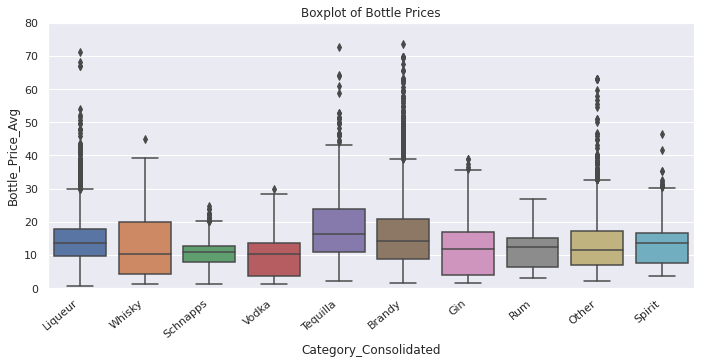

In [133]:
df_2020_pd = df_2020.toPandas()
plt.figure(figsize=(10,5))
ax1 = sns.boxplot(x="Category_Consolidated", y="Bottle_Price_Avg", data=df_2020_pd)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Boxplot of Bottle Prices')
plt.ylim([0,80])
plt.show()

#### 4.5.6) Multicollinearity Check

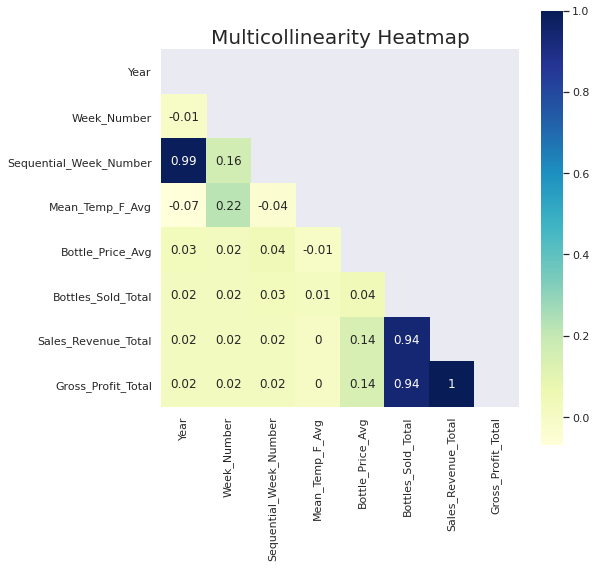

In [136]:
df_pd= df.toPandas()

plt.figure(figsize=(8,8))
mask = np.zeros_like(df_pd.corr())
mask[np.triu_indices_from(mask)] = True

sns.set(rc={'figure.figsize': (10,10)})
sns.heatmap(df_pd.corr().round(2), square=True, cmap='YlGnBu', annot=True, mask=mask);
plt.title('Multicollinearity Heatmap', fontsize=20);

## Section 5) Modeling

To create an accurate prediction, we experimented with several different types of models. These models fell into two broad categories, which were linear regressions and tree-based regressions. For linear regression models, we utilized the Linear Regression (ordinary least squares), Lasso and Ridge models. For tree-based regressions, we utilized Decision Trees, Gradient Boosted Trees, and Random Forest models. We trained all our models on data from 2015 to 2019 using a 70%-30% split, and then tested our models on 2020 data.

Before the models were created, we performed a pre-processing step. In this step, all categorical variables (city, liquor category, and bottle volume) were string indexed, one-hot encoded, and made into dummy variables. The features were then converted into a 'features' column by RFormula. 

### 5.1) Data Pre-Processing ###

**Create a Copy of Weekly Spark Dataframe**

In [137]:
df1 = df

**String Indexer and OneHotEncoder for Bottle Volume**

In [138]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexing Bottle_Volume columns
indexer = StringIndexer(inputCol='Bottle_Volume_ml_Consolidated', outputCol='Bottle_Volume_indx')

# Assign index value to strings
indexer = indexer.fit(df1)

# Create column with index values
df1 = indexer.transform(df1)

# One-Hot Encoding
onehot = OneHotEncoder(inputCols=['Bottle_Volume_indx'], outputCols=['Bottle_Volume_dummy'])
onehot = onehot.fit(df1)
df1 = onehot.transform(df1)

# Check converted columns
df1.select('Bottle_Volume_ml_Consolidated','Bottle_Volume_indx','Bottle_Volume_dummy').distinct().sort('Bottle_Volume_indx').show()

# Drop useless original colums
df1 = df1.drop('Bottle_Volume_indx')

#df1 = df1.drop('Bottle_Volume_ml_Consolidated','Bottle_Volume_indx')

+-----------------------------+------------------+-------------------+
|Bottle_Volume_ml_Consolidated|Bottle_Volume_indx|Bottle_Volume_dummy|
+-----------------------------+------------------+-------------------+
|                          750|               0.0|      (5,[0],[1.0])|
|                        Other|               1.0|      (5,[1],[1.0])|
|                         1000|               2.0|      (5,[2],[1.0])|
|                          375|               3.0|      (5,[3],[1.0])|
|                          200|               4.0|      (5,[4],[1.0])|
|                          100|               5.0|          (5,[],[])|
+-----------------------------+------------------+-------------------+



**String Indexer and OneHotEncoder for City**

In [139]:
#Indexing City columns
indexer = StringIndexer(inputCol='City_Consolidated', outputCol='City_indx')

#Assign index value to strings
indexer = indexer.fit(df1)

#Create column with index values
df1 = indexer.transform(df1)

# One-Hot Encoding
onehot = OneHotEncoder(inputCols=['City_indx'], outputCols=['City_dummy'])
onehot = onehot.fit(df1)
df1 = onehot.transform(df1)

# Check converted columns
df1.select('City_Consolidated','City_indx','City_dummy').distinct().sort('City_indx').show(25)

# Drop useless original colums
df1 = df1.drop('City_indx')

#df1 = df1.drop('City_Consolidated','City_indx')

+-----------------+---------+---------------+
|City_Consolidated|City_indx|     City_dummy|
+-----------------+---------+---------------+
|            Other|      0.0| (20,[0],[1.0])|
|       Des Moines|      1.0| (20,[1],[1.0])|
|     Cedar Rapids|      2.0| (20,[2],[1.0])|
|        Davenport|      3.0| (20,[3],[1.0])|
|         Waterloo|      4.0| (20,[4],[1.0])|
|       Sioux City|      5.0| (20,[5],[1.0])|
|   Council Bluffs|      6.0| (20,[6],[1.0])|
|        Iowa City|      7.0| (20,[7],[1.0])|
|          Dubuque|      8.0| (20,[8],[1.0])|
|             Ames|      9.0| (20,[9],[1.0])|
|      Cedar Falls|     10.0|(20,[10],[1.0])|
|       Coralville|     11.0|(20,[11],[1.0])|
|  West Des Moines|     12.0|(20,[12],[1.0])|
|       Mason City|     13.0|(20,[13],[1.0])|
|     Marshalltown|     14.0|(20,[14],[1.0])|
|           Ankeny|     15.0|(20,[15],[1.0])|
|        Muscatine|     16.0|(20,[16],[1.0])|
|       Fort Dodge|     17.0|(20,[17],[1.0])|
|       Bettendorf|     18.0|(20,[

**String Indexer and OneHotEncoder for Liquor Category**

In [140]:
#Indexing Category columns
indexer = StringIndexer(inputCol='Category_Consolidated', outputCol='Category_indx')

#Assign index value to strings
indexer = indexer.fit(df1)

#Create column with index values
df1 = indexer.transform(df1)

# One-Hot Encoding
onehot = OneHotEncoder(inputCols=['Category_indx'], outputCols=['Category_dummy'])
onehot = onehot.fit(df1)
df1 = onehot.transform(df1)

# Check converted columns
df1.select('Category_Consolidated','Category_indx','Category_dummy').distinct().sort('Category_indx').show()

# Drop useless original colums
df1 = df1.drop('Category_indx')

#df1 = df1.drop('Category_Consolidated','Category_indx')


+---------------------+-------------+--------------+
|Category_Consolidated|Category_indx|Category_dummy|
+---------------------+-------------+--------------+
|               Whisky|          0.0| (9,[0],[1.0])|
|               Brandy|          1.0| (9,[1],[1.0])|
|                Vodka|          2.0| (9,[2],[1.0])|
|              Liqueur|          3.0| (9,[3],[1.0])|
|                  Gin|          4.0| (9,[4],[1.0])|
|                  Rum|          5.0| (9,[5],[1.0])|
|             Tequilla|          6.0| (9,[6],[1.0])|
|             Schnapps|          7.0| (9,[7],[1.0])|
|                Other|          8.0| (9,[8],[1.0])|
|               Spirit|          9.0|     (9,[],[])|
+---------------------+-------------+--------------+



In [141]:
# Columns Check

df1.show(5)


+----+-----------+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+------------------+-------------------+---------------+--------------+
|Year|Week_Number|Sequential_Week_Number|City_Consolidated|Category_Consolidated|Bottle_Volume_ml_Consolidated|Mean_Temp_F_Avg|Bottle_Price_Avg|Bottles_Sold_Total|Sales_Revenue_Total|Gross_Profit_Total|Bottle_Volume_dummy|     City_dummy|Category_dummy|
+----+-----------+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+------------------+-------------------+---------------+--------------+
|2017|         43|                   149|   Council Bluffs|                Vodka|                          200|          40.61|            2.06|               392|             809.42|            271.03|      (5,[4],[1.0])| (20,[6],[1.0])|

In [142]:
# Making a copy for future use
df2 = df1

# Seperating spark data frames by year

df_2020 = df1.filter(df1['Year'] == 2020)
df1 = df1.filter(df1['Year'] < 2020)

In [143]:
# Linear - drop year and week_number

df_linear = df1.drop('Year', 'Week_Number', 'Sales_Revenue_Total', 'Gross_Profit_Total')
df_2020_linear = df_2020.drop('Year', 'Week_Number', 'Sales_Revenue_Total', 'Gross_Profit_Total',)

# Tree - drop year and sequential week number

df_tree = df1.drop('Year', 'Sequential_Week_Number', 'Sales_Revenue_Total', 'Gross_Profit_Total')
df_2020_tree = df_2020.drop('Year', 'Sequential_Week_Number', 'Sales_Revenue_Total', 'Gross_Profit_Total')

**Creating Seperate Datasets for Models**

In [144]:
from pyspark.ml.feature import RFormula

# 2015-2019 Linear Model

supervised_linear = RFormula(formula="Bottles_Sold_Total ~ . - City_Consolidated - Bottle_Volume_ml_Consolidated - Category_Consolidated")
fittedRF_linear = supervised_linear.fit(df_linear)  
preparedDF_linear1 = fittedRF_linear.transform(df_linear)  # transform

# 2020 Linear Model

supervised_linear = RFormula(formula="Bottles_Sold_Total ~ . - City_Consolidated - Bottle_Volume_ml_Consolidated - Category_Consolidated")
fittedRF_linear = supervised_linear.fit(df_2020_linear) 
preparedDF_linear2 = fittedRF_linear.transform(df_2020_linear)  

# 2015-2019 Tree-Based Model

supervised_tree = RFormula(formula="Bottles_Sold_Total ~ . - City_Consolidated - Bottle_Volume_ml_Consolidated - Category_Consolidated")
fittedRF_tree = supervised_tree.fit(df_tree) 
preparedDF_tree1 = fittedRF_tree.transform(df_tree)  

# 2020 Tree-Based Model

supervised_tree = RFormula(formula="Bottles_Sold_Total ~ . - City_Consolidated - Bottle_Volume_ml_Consolidated - Category_Consolidated")
fittedRF_tree = supervised_tree.fit(df_2020_tree) 
preparedDF_tree2 = fittedRF_tree.transform(df_2020_tree) 


In [145]:
#Check features and label datatype to ensure they are vector and double

preparedDF_linear1.printSchema()
preparedDF_linear1.show(1, False)

preparedDF_linear2.printSchema()
preparedDF_linear2.show(1, False)

preparedDF_tree1.printSchema()
preparedDF_tree1.show(1, False)

preparedDF_tree2.printSchema()
preparedDF_tree2.show(1, False)

root
 |-- Sequential_Week_Number: long (nullable = true)
 |-- City_Consolidated: string (nullable = true)
 |-- Category_Consolidated: string (nullable = true)
 |-- Bottle_Volume_ml_Consolidated: string (nullable = true)
 |-- Mean_Temp_F_Avg: double (nullable = true)
 |-- Bottle_Price_Avg: double (nullable = true)
 |-- Bottles_Sold_Total: long (nullable = true)
 |-- Bottle_Volume_dummy: vector (nullable = true)
 |-- City_dummy: vector (nullable = true)
 |-- Category_dummy: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+--------------+--------------+---------------------------------------------------+-----+
|Sequential_Week_Number|City_Consolidated|Category_Consolidated|Bottle_Volume_ml_Consolidated|Mean_Temp_F_Avg|Bottle_Price_Avg|Bottles_Sold_Total|Bottle_Volume_dummy

In [146]:
#Extract Tree Feature List for future use

featureCols_tree = pd.DataFrame(preparedDF_tree1.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF_tree1.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols_tree = featureCols_tree.set_index('idx')
featureCols_list_tree = featureCols_tree['name'].to_list()

### 5.2) Linear Regression (OLS)

In [147]:
# Recreate train, test dataset for all linear models

train, test = preparedDF_linear1.randomSplit([0.7, 0.3], seed = 843)

In [148]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

regression = LinearRegression(labelCol='label', featuresCol= 'features')
regression = regression.fit(train)

# Predict with the model

prediction_linear = regression.transform(test)

# Inspect result
prediction_linear.select("prediction", "Bottles_Sold_Total").show(5)

# Evaluate model on train data

trainSummary = regression.summary
print("2015-2019 Train RMSE: %f" % trainSummary.rootMeanSquaredError)
print("2015-2019 Train R^2: %f" % trainSummary.r2)

print()

# Evaluate model on test data

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
rmse = evaluator.evaluate(prediction_linear, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_linear, {evaluator.metricName: "r2"})

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))

+-----------------+------------------+
|       prediction|Bottles_Sold_Total|
+-----------------+------------------+
|385.4849723297925|               392|
|76.52597482162628|                43|
|993.4391009416308|               479|
|1247.017301946024|               739|
|1221.383081928106|               614|
+-----------------+------------------+
only showing top 5 rows

2015-2019 Train RMSE: 1230.661547
2015-2019 Train R^2: 0.349799

2015-2019 Test RMSE: 1215.9066197115055
2015-2019 Test R^2: 0.34737005270786003


In [149]:
# 2020 Prediction Using Liner Regression

prediction_linear2 = regression.transform(preparedDF_linear2)
prediction_linear2.select("prediction", "Bottles_Sold_Total").show(5)

# Evaluate model on test data

rmse = evaluator.evaluate(prediction_linear2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_linear2, {evaluator.metricName: "r2"})

print('2020 Test RMSE: ' + str(rmse))
print('2020 Test R^2: ' + str(r2))

+------------------+------------------+
|        prediction|Bottles_Sold_Total|
+------------------+------------------+
|115.27924365340755|                78|
| 626.5382886210905|               888|
|-205.0134336424021|                10|
| 659.4217004035531|               106|
|368.13671668474626|               134|
+------------------+------------------+
only showing top 5 rows

2020 Test RMSE: 1545.6447835291833
2020 Test R^2: 0.31931405532980417


### 5.3) Lasso Regression

In [150]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lasso = LinearRegression(labelCol='label', featuresCol= 'features', elasticNetParam=1)
lasso = lasso.fit(train)

# Predict with the model

prediction_linear = lasso.transform(test)

# Inspect result

prediction_linear.select("prediction", "Bottles_Sold_Total").show(5)

#Evaluate model on train data

trainSummary = lasso.summary
print("2015-2019 Train RMSE: %f" % trainSummary.rootMeanSquaredError)
print("2015-2019 Train R^2: %f" % trainSummary.r2)

print()

#Evaluate model on test data

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
rmse = evaluator.evaluate(prediction_linear, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_linear, {evaluator.metricName: "r2"})

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))

+-----------------+------------------+
|       prediction|Bottles_Sold_Total|
+-----------------+------------------+
|385.4849723297925|               392|
|76.52597482162628|                43|
|993.4391009416308|               479|
|1247.017301946024|               739|
|1221.383081928106|               614|
+-----------------+------------------+
only showing top 5 rows

2015-2019 Train RMSE: 1230.661547
2015-2019 Train R^2: 0.349799

2015-2019 Test RMSE: 1215.9066197115055
2015-2019 Test R^2: 0.34737005270786003


In [151]:
# 2020 Prediction Using Lasso Regression

prediction_linear2 = lasso.transform(preparedDF_linear2)
prediction_linear2.select("prediction", "Bottles_Sold_Total").show(5)

rmse = evaluator.evaluate(prediction_linear2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_linear2, {evaluator.metricName: "r2"})

print('2020 Test RMSE: ' + str(rmse))
print('2020 Test R^2: ' + str(r2))

+------------------+------------------+
|        prediction|Bottles_Sold_Total|
+------------------+------------------+
|115.27924365340755|                78|
| 626.5382886210905|               888|
|-205.0134336424021|                10|
| 659.4217004035531|               106|
|368.13671668474626|               134|
+------------------+------------------+
only showing top 5 rows

2020 Test RMSE: 1545.6447835291833
2020 Test R^2: 0.31931405532980417


### 5.4) Ridge Regression

In [152]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

ridge = LinearRegression(labelCol='label', featuresCol= 'features', elasticNetParam=0)
ridge = ridge.fit(train)

# Predict with the model

prediction_linear = ridge.transform(test)

# Inspect result

prediction_linear.select("prediction", "Bottles_Sold_Total").show(5)

#Evaluate model

trainSummary = ridge.summary
print("2015-2019 Train RMSE: %f" % trainSummary.rootMeanSquaredError)
print("201-2019 Train R^2: %f" % trainSummary.r2)

print()
#Evaluate model on test data

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
rmse = evaluator.evaluate(prediction_linear, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_linear, {evaluator.metricName: "r2"})

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))

+-----------------+------------------+
|       prediction|Bottles_Sold_Total|
+-----------------+------------------+
|385.4849723297925|               392|
|76.52597482162628|                43|
|993.4391009416308|               479|
|1247.017301946024|               739|
|1221.383081928106|               614|
+-----------------+------------------+
only showing top 5 rows

2015-2019 Train RMSE: 1230.661547
201-2019 Train R^2: 0.349799

2015-2019 Test RMSE: 1215.9066197115055
2015-2019 Test R^2: 0.34737005270786003


In [153]:
# 2020 Prediction Using Ridge Regression

prediction_linear2 = ridge.transform(preparedDF_linear2)
prediction_linear2.select("prediction", "Bottles_Sold_Total").show(5)

rmse = evaluator.evaluate(prediction_linear2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_linear2, {evaluator.metricName: "r2"})

print('Test RMSE: ' + str(rmse))
print('Test R^2: ' + str(r2))

+------------------+------------------+
|        prediction|Bottles_Sold_Total|
+------------------+------------------+
|115.27924365340755|                78|
| 626.5382886210905|               888|
|-205.0134336424021|                10|
| 659.4217004035531|               106|
|368.13671668474626|               134|
+------------------+------------------+
only showing top 5 rows

Test RMSE: 1545.6447835291833
Test R^2: 0.31931405532980406


### 5.5) Gradient Boosted Tree

In [154]:
train, test = preparedDF_tree1.randomSplit([0.7, 0.3], seed = 400)

from pyspark.ml.regression import GBTRegressor

# Train model

gb = GBTRegressor(featuresCol="features", labelCol="label", predictionCol="prediction", seed=843)
gb = gb.fit(train)

# Predict with the model

prediction_tree = gb.transform(test)

# Inspect result

prediction_tree.select("prediction", "Bottles_Sold_Total").show(5)

#Evaluate model on test data

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
rmse = evaluator.evaluate(prediction_tree, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_tree, {evaluator.metricName: "r2"})

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))


+-------------------+------------------+
|         prediction|Bottles_Sold_Total|
+-------------------+------------------+
| 225.37282601274936|               367|
|-14.498220053448996|                14|
|  69.28558887046901|                55|
|  54.66210661836859|               137|
| 126.77726783539254|                32|
+-------------------+------------------+
only showing top 5 rows

2015-2019 Test RMSE: 518.8045466868962
2015-2019 Test R^2: 0.8797934777911299


In [155]:
# Evaluate the model

from pyspark.ml.evaluation import RegressionEvaluator

# Predict with the model

prediction_tree2 = gb.transform(preparedDF_tree2)

# Select columns to compute test error

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")

# Create evaluation metrics

rmse = evaluator.evaluate(prediction_tree2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_tree2, {evaluator.metricName: "r2"})

# Print Model Metrics

print('2020 Test RMSE: '  + str(rmse))
print('2020 Test R^2: ' + str(r2))

2020 Test RMSE: 827.2551949666455
2020 Test R^2: 0.8050126646981687


### 5.6) Random Forest

In [57]:
from pyspark.ml.regression import RandomForestRegressor

# Train model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", predictionCol="prediction", seed=843)
rf = rf.fit(train)

# Predict with the model
prediction_tree = rf.transform(test)

# Inspect result

prediction_tree.select("prediction", "Bottles_Sold_Total").show(5)

#Evaluate model on test data

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
rmse = evaluator.evaluate(prediction_tree, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_tree, {evaluator.metricName: "r2"})

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))


+------------------+------------------+
|        prediction|Bottles_Sold_Total|
+------------------+------------------+
| 271.6388727078159|               367|
|155.28079748118958|                14|
|169.00194277593647|                55|
| 182.3989214688342|               137|
|166.44177272562538|                32|
+------------------+------------------+
only showing top 5 rows

2015-2019 Test RMSE: 744.3698568188428
2015-2019 Test R^2: 0.7525439697176803


In [58]:
# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

# Predict with the model

prediction_tree2 = rf.transform(preparedDF_tree2)

# Select columns to compute test error

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")

# Create evaluation metrics

rmse = evaluator.evaluate(prediction_tree2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_tree2, {evaluator.metricName: "r2"})

# Print Model Metrics

print('2020 Test RMSE: '  + str(rmse))
print('2020 Test R^2: ' + str(r2))

2020 Test RMSE: 1083.4322957575855
2020 Test R^2: 0.665550190844405


### 5.7) Decision Tree

In [59]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Train model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", predictionCol="prediction", seed=843)
dt = dt.fit(train)

# Predict with the model
prediction_tree = dt.transform(test)

# Inspect result

prediction_tree.select("prediction", "Bottles_Sold_Total").show(5)

#Evaluate model on test data

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
rmse = evaluator.evaluate(prediction_tree, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_tree, {evaluator.metricName: "r2"})

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))


+------------------+------------------+
|        prediction|Bottles_Sold_Total|
+------------------+------------------+
|124.93121514107611|               367|
|124.93121514107611|                14|
|124.93121514107611|                55|
|124.93121514107611|               137|
|124.93121514107611|                32|
+------------------+------------------+
only showing top 5 rows

2015-2019 Test RMSE: 607.6123276341236
2015-2019 Test R^2: 0.8351178512708219


In [60]:
# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

# Predict with the model

prediction_tree2 = dt.transform(preparedDF_tree2)

# Select columns to compute test error

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")

# Create evaluation metrics

rmse = evaluator.evaluate(prediction_tree2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction_tree2, {evaluator.metricName: "r2"})

# Print Model Metrics

print('2020 Test RMSE: '  + str(rmse))
print('2020 Test R^2: ' + str(r2))

2020 Test RMSE: 891.019190264064
2020 Test R^2: 0.773795357717559


### 5.8) Hyperparameter Tuning of Gradient Boosted Tree ###

In [55]:
# Source = https://www.sparkitecture.io/machine-learning/regression/gradient-boosted-trees

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

#Create GBT

gb = GBTRegressor(labelCol="label", featuresCol="features", predictionCol="prediction")

#Create Evaluator

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction", metricName="rmse")

#Setup gridsearch

gbparamGrid = ParamGridBuilder() \
               .addGrid(gb.maxDepth, [5, 10]) \
               .addGrid(gb.maxBins, [10, 20]) \
               .addGrid(gb.maxIter,[5]) \
               .build()

In [ ]:
# Train Validation Split Tuning
"""
tvs = TrainValidationSplit(estimator = gb,
                           estimatorParamMaps = gbparamGrid,
                           evaluator = evaluator,
                           trainRatio = 0.8)

gbtvs = tvs.fit(train)
"""

In [ ]:
# Cross Validation Tuning

cv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

gbcv = cv.fit(train)


In [64]:
# Test model on 2015-2019
"""
gbtvs_prediction_tree = gbtvs.transform(test)

# Create evaluation metrics

rmse = evaluator.evaluate(gbtvs_prediction_tree, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(gbtvs_prediction_tree, {evaluator.metricName: "r2"})

# Print Tuned Model Metrics

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))
"""

'\ngbtvs_prediction_tree = gbtvs.transform(test)\n\n# Create evaluation metrics\n\nrmse = evaluator.evaluate(gbtvs_prediction_tree, {evaluator.metricName: "rmse"})\nr2 = evaluator.evaluate(gbtvs_prediction_tree, {evaluator.metricName: "r2"})\n\n# Print Tuned Model Metrics\n\nprint(\'2015-2019 Test RMSE: \' + str(rmse))\nprint(\'2015-2019 Test R^2: \' + str(r2))\n'

In [57]:
# Test model on 2015-2019

gbcv_prediction_tree = gbcv.transform(test)

# Create evaluation metrics

rmse = evaluator.evaluate(gbcv_prediction_tree , {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(gbcv_prediction_tree , {evaluator.metricName: "r2"})

# Print Tuned Model Metrics

print('2015-2019 Test RMSE: ' + str(rmse))
print('2015-2019 Test R^2: ' + str(r2))

2015-2019 Test RMSE: 458.2796222032894
2015-2019 Test R^2: 0.9062045917072297


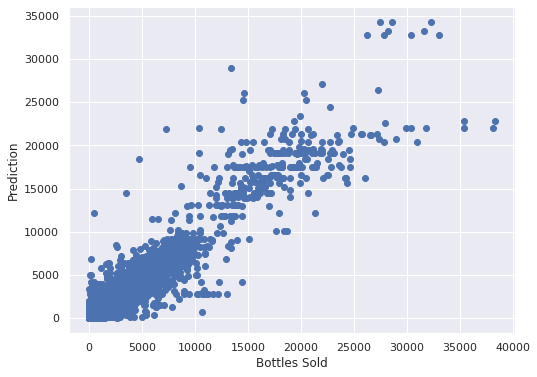

In [78]:
#Graph predictions vs actual Bottles Sold
import matplotlib.pyplot as plt

gbtResult = gbcv_prediction_tree.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(gbtResult.label, gbtResult.prediction, 'bo')
plt.xlabel('Bottles Sold')
plt.ylabel('Prediction')
plt.show()

Text(0.5, 1.0, 'Feature Importance')

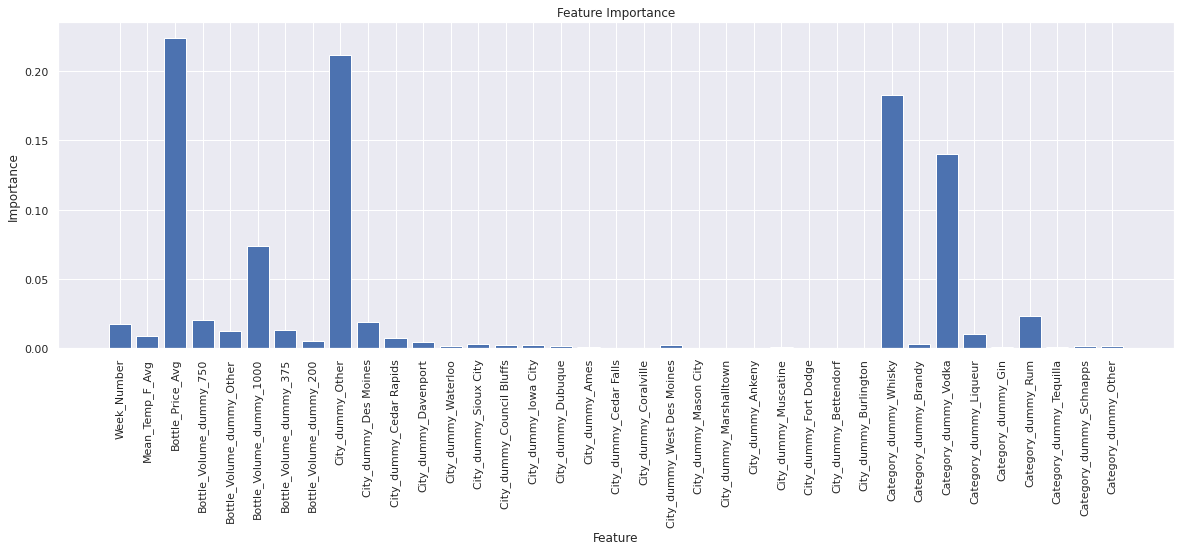

In [81]:
#Graph bar chart of model feature importance
bestModel = gbcv.bestModel
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.rcParams["figure.figsize"] = (20,6)
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, featureCols_list_tree, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance')

**Apply Best Model to 2020 Data**

In [82]:

from pyspark.ml.evaluation import RegressionEvaluator

# Predict with the model

gbcv_prediction_tree2 = gbcv.transform(preparedDF_tree2)

# Select columns to compute test error

evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")

# Create evaluation metrics

rmse = evaluator.evaluate(gbcv_prediction_tree2, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(gbcv_prediction_tree2, {evaluator.metricName: "r2"})

# Print Model Metrics

print('2020 Test RMSE: '  + str(rmse))
print('2020 Test R^2: ' + str(r2))

2020 Test RMSE: 757.174170746551
2020 Test R^2: 0.8366500600299207


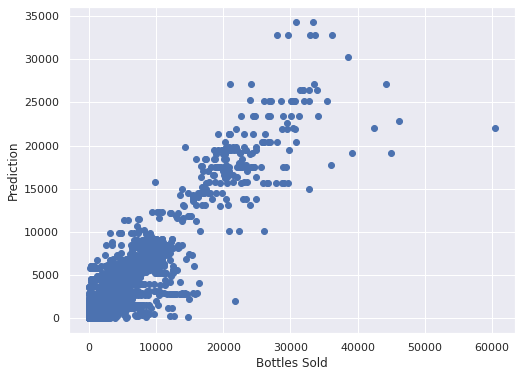

In [83]:
gbtResult = gbcv_prediction_tree2.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(gbtResult.label, gbtResult.prediction, 'bo')
plt.xlabel('Bottles Sold')
plt.ylabel('Prediction')
plt.show()

**Model Predictions vs. Actual Data**

In [70]:
# Prediction by week number

gbcv_week_df= gbcv_prediction_tree2.groupBy('Week_Number') \
.agg({'Bottles_Sold_Total':'sum', 'prediction':'sum'}) \
.withColumnRenamed("SUM(prediction)", "Prediction")\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.orderBy(F.desc("Week_Number"))

gbcv_week_df = gbcv_week_df.toPandas()
gbcv_week_df.head(10)

,Week_Number,Prediction,Bottles_Sold
0,53,493488.520882,496510
1,52,512041.171367,673000
2,51,500979.475564,640919
3,50,515408.891247,657040
4,49,527379.330869,556511
5,48,530524.085223,498058
6,47,508450.552899,598897
7,46,514205.377717,552055
8,45,501552.562455,618692
9,44,521393.976174,636140


In [71]:
# Prediction by City

gbcv_city_df= gbcv_prediction_tree2.groupBy('City_Consolidated') \
.agg({'Bottles_Sold_Total':'sum', 'prediction':'sum'}) \
.withColumnRenamed("SUM(prediction)", "Prediction")\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.orderBy(F.desc("City_Consolidated"))

gbcv_city_df = gbcv_city_df.toPandas()
gbcv_city_df.head(10)


,City_Consolidated,Prediction,Bottles_Sold
0,West Des Moines,7.393363e+05,1044387
1,Waterloo,1.001709e+06,1179735
2,Urbandale,4.371369e+05,446742
3,Sioux City,7.180906e+05,1004425
4,Other,9.494073e+06,11641724
5,Muscatine,3.837323e+05,349401
6,Mason City,4.607673e+05,502339
7,Marshalltown,3.670095e+05,307260
8,Iowa City,7.543230e+05,777794
9,Fort Dodge,3.941014e+05,353950


In [72]:
# Prediction by Bottle Volume

gbcv_bottle_volume_df= gbcv_prediction_tree2.groupBy('Bottle_Volume_ml_Consolidated') \
.agg({'Bottles_Sold_Total':'sum', 'prediction':'sum'}) \
.withColumnRenamed("SUM(prediction)", "Prediction")\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.orderBy(F.desc("Bottle_Volume_ml_Consolidated"))

gbcv_bottle_volume_df = gbcv_bottle_volume_df.toPandas()

gbcv_bottle_volume_df.head(10)

,Bottle_Volume_ml_Consolidated,Prediction,Bottles_Sold
0,Other,5.501527e+06,7115237
1,750,8.780600e+06,10302476
2,375,2.917029e+06,3683574
3,200,1.793889e+06,2062027
4,1000,4.767893e+06,4011486
5,100,1.625240e+06,2655800


In [73]:
# Prediction by Liquor Category

gbcv_category_df= gbcv_prediction_tree2.groupBy('Category_Consolidated') \
.agg({'Bottles_Sold_Total':'sum', 'prediction':'sum'}) \
.withColumnRenamed("SUM(prediction)", "Prediction")\
.withColumnRenamed("SUM(Bottles_Sold_Total)", "Bottles_Sold")\
.orderBy(F.desc("Category_Consolidated"))

gbcv_category_df = gbcv_category_df.toPandas()
gbcv_category_df.head(10)


,Category_Consolidated,Prediction,Bottles_Sold
0,Whisky,8.078583e+06,10854489
1,Vodka,7.393899e+06,8118389
2,Tequilla,9.693495e+05,1403198
3,Spirit,4.572954e+05,386786
4,Schnapps,9.914429e+05,1024999
5,Rum,2.725686e+06,2755816
6,Other,7.848718e+05,1392080
7,Liqueur,1.873151e+06,1567337
8,Gin,7.700752e+05,677292
9,Brandy,1.341825e+06,1650214


**Rolling 1-Week Experiment With Retraining**

In [74]:
df2 = df2.drop('Sales_Revenue_Total', 'Gross_Profit_Total' )

In [75]:
# 2015-2020 Tree

supervised_tree = RFormula(formula="Bottles_Sold_Total ~ . - City_Consolidated - Bottle_Volume_ml_Consolidated - Category_Consolidated - Year - Sequential_Week_Number")
fittedRF_tree = supervised_tree.fit(df2) 
preparedDF2_tree1 = fittedRF_tree.transform(df2)  
preparedDF2_tree1.show(2)


+----+-----------+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+---------------+--------------+--------------------+-----+
|Year|Week_Number|Sequential_Week_Number|City_Consolidated|Category_Consolidated|Bottle_Volume_ml_Consolidated|Mean_Temp_F_Avg|Bottle_Price_Avg|Bottles_Sold_Total|Bottle_Volume_dummy|     City_dummy|Category_dummy|            features|label|
+----+-----------+----------------------+-----------------+---------------------+-----------------------------+---------------+----------------+------------------+-------------------+---------------+--------------+--------------------+-----+
|2019|         28|                   239|   Council Bluffs|                Vodka|                         1000|          77.79|           15.29|               738|      (5,[2],[1.0])| (20,[6],[1.0])| (9,[2],[1.0])|(37,[0,1,2,5,14,3...|738.0|
|2019|         52|              

In [107]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dict1= {}

for week in range(0,8):
    
    gb = GBTRegressor(featuresCol="features", labelCol="label", predictionCol="prediction", seed=843)

    evaluator = RegressionEvaluator(labelCol="Bottles_Sold_Total", predictionCol= "prediction")
    
    one = preparedDF2_tree1.filter( preparedDF2_tree1['Sequential_Week_Number']< (265 + week) )
    two = preparedDF2_tree1.filter( preparedDF2_tree1['Sequential_Week_Number']== (265 + week) )                             

    train, test = one.randomSplit([0.7, 0.3], seed = 843)

    gb = gb.fit(train)
    
    gb_prediction_tree2 = gb.transform(two) # predict for week

    rmse = evaluator.evaluate(gb_prediction_tree2, {evaluator.metricName: "rmse"})
    r2 = evaluator.evaluate(gb_prediction_tree2, {evaluator.metricName: "r2"})

    entry= {'period': 265 + week, 'week': week, 'rmse': rmse, 'r2': r2}

    dict1[week] = entry
                         

In [105]:
dict1

{50: {'period': 315,
  'week': 50,
  'rmse': 933.8726109842783,
  'r2': 0.8248766161636993},
 51: {'period': 316,
  'week': 51,
  'rmse': 1308.4867411244968,
  'r2': 0.7535970530984004},
 52: {'period': 317,
  'week': 52,
  'rmse': 655.8192531311093,
  'r2': 0.8478548937460669}}

In [106]:
pd.DataFrame.from_dict(dict1, orient= 'index')


,period,week,rmse,r2
50,315,50,933.872611,0.824877
51,316,51,1308.486741,0.753597
52,317,52,655.819253,0.847855


## Section 6) Analysis & Evaluation

**Linear Models:**

Judging from the root mean squared error and squared correlation values, all three linear models performed poorly. The poor performance of these models can be attributed to the seasonal variation present in our dataset, which linear models struggle to explain.

**Tree-Based Models:**

It is evident from the data that tree-based regressions outperformed their linear counterparts. Tree-based regressions had not only higher squared correlation values, but also lower root mean squared error values. Unlike the linear models, the three tree-based regression models did very well in capturing seasonal effects.

When the performance of the tree-based regression models was analyzed, we saw a slight drop in squared correlation from the training and validation set to the testing set. This indicates that the models do not suffer from overfitting. Furthermore, we utilized cross-validation and train-validation-split to get an even more accurate model. In our case, the Gradient Boosted Tree with cross-validation had the highest squared corrleation and lowest root mean suqared error value. 

**Predictions vs. Actual Data:**

Next, it was time to apply one of the tree-based regression models to the 2020 dataset and see how close our predictions for bottles sold by alcohol type, city, bottle volume and week were to actual sales. We decided to use the Gradient Boosted Tree for creating the predictions because it had a high squared correlation value and the lowest root mean squared error. 

Overall, the decision tree was off by 9.27% on average for alcohol type. The model performed well on predicting purchases of gin and schnapps. However, it performed poorly when predicting brandy, tequilla, liqueur, rum and vodka. The model also fared poorly when trying to predict sales in the 'Other' category.

For predicting purchases by city, the model was off by an average of 9.27%. Interestingly, the model did well in predicting purchases in Ames, Waterloo, Mason City, Coralville and Bettendorof and Waterloo. The model did poorly in predicting sales in cities such as Marshaltown, Fort Dodge, Cedar Rapids, Des Moines, West Des Moines and Burlington. 

The decision tree was on average off by 9.27% for predicting sales by bottle volume. It can be seen that the model performs poorly when predicting sales for bottle volumes of 100 ml, and 1000 ml. It did well for 200 ml, 375 ml and 750 ml bottles. 

**Rolling 1-Week Experiment With Retraining**

After seeing that the Gradient Boosted Tree did relatively well in predicting wholesale liquor sales, we decided to try a new experiment to see if the model’s root mean squared error and squared correlation values could be improved. This experiment mimics a real-life scenario where the model would be used to predict wholesale liquor purchases one week into the future and then use the actual sales data for that week to retrain the model. Once the model has been retrained, a new one-week prediction will be created. This cycle repeated itself to cover fifty-three weeks in 2020. The training and validation split used was still 70%-30%. The Gradient Boosted Tree in this experiment did not use cross-validaiton because the computation crashed the kernel several times, and it took too long to complete when it did work.

The experiment showed that when the Gradient Boosted Tree is updated with new data every week, the model’s average root mean squared error and squared correlation improve. This experiment showed us that using the Gradient Boosted Tree and updating it with new data will yield better results as the weeks go by.


## Section 7) Conclusion & Recommendations

To summarize our project, we chose a real-world business problem of accurately predicting sales based on historical data. For this problem, we used a dataset that is publicly available and easy to access. We analyzed and cleaned the data in order to make it ready for use in our modeling exercises. We also conducted an exploratory analysis to find any interesting patterns or outliers that would inform our model selection. 

Finally, we split the dataset into a training dataset (2015-2019) and a test dataset (2020). We used the training dataset to train six linear and tree-based models. We then used those models on our test dataset to predict wholesale liquor sales in Iowa for 2020, and evaluated their performance. Based on the root mean squared error from those six models, we chose the Gradient Boosted Tree as the best forecasting model for our dataset. 

Once we chose the Gradient Boosted Tree as our model, we further improved its parameters via cross-validation,and tried a few more experiments to see if we could understand the model's performance by looking at sales by alcohol type, city, and bottle volume. We also ran experiments to iteratively increase the size of our training dataset by including data sequentially from our testing dataset (2020). We have already seen that our model is not overfitted, which is why we could afford to update the training dataset. We saw better results as a result of this process.

From our exhaustive analysis, we recommend that the Alcoholic Beverages Commission look at using Gradient Boosted Trees to make sales forecasts one week into the future, and update the model with new training data at the end of each week. This will help the commission plan future purchases from distilleries and importers, better manage workforce scheduling, and minimize transportation and logistics costs. Using a Gradient Boosted Tree will produce a lower root mean squared error, which is critical for making accurate predictions.

## Section 8) Next Steps

Going ahead, we want to add more explanatory variables to our dataset so that we can have even more accurate predictions. For example, adding brands such as Johnnie Walker, Jack Daniel's, and others could potentially help us predict our sales with more accuracy. However, the computing resource requirements may be much higher than they are now. Hence, this analysis will have to be performed using a very powerful computer with a large number of workers and secondary workers in the cloud. We would also like to add population numbers for each city to see how population changes affect each city's wholesale liquor purchase over time. We would also look at calculating the net present value of improved predictions by bringing in costs to transport and store alcohol. Calculating the net present value will show us how much the wholesaler's bottom line improves over time. 

Given enough time and resources, we would be keen to conduct more experiments to create a better model that predicts sales with a much higher squared correlation and lower root mean squared error. 
